In [103]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation
from scipy.special import binom
import scipy.integrate as cit
from itertools import combinations
import pandas as pd

In [152]:
safety = 0.3 # percent of data at safety margin left and right
safetymargin = int(window_size*safety)
print(safetymargin)

300


In [105]:

#lokale Definition der Klasse
class CPSegmentFit:
	'''
	The `CP_segment_fit` class contains tools to perform a Bayesian segmential fit under the assumption
	of a certain number of change points.

	:param x_data: Given data on the x-axis. Saved in attribute `x`.
	:type x_data: One-dimensional numpy array of floats.
	:param y_data: Given data on the y-axis. Saved in attribute `y`.
	:type y_data: One-dimensional numpy array of floats.
	:param number_expected_changepoints: Number of expected change points in the fit.
	:type number_expected_changepoints: int
	:param num_MC_cp_samples: Maximum number of MC summands that shall be incorporated in order to
		extrapolate the fit. Saved in attribute `n_MC_samples`.

	:type num_MC_cp_samples: int
	:param n_MC_samples: Attribute contains the number of MC summands of the performed extraplation
		of the fit. It is exact, whenever the number of possible change point
		configurations is smaller than `num_MC_cp_samples`.

	:type n_MC_samples: int
	:param cp_prior_pdf: Attribute that contains the flat prior probability of the considered change point
		configurations.

	:type cp_prior_pdf: One-dimensional numpy array of floats.
	:param num_cp_configs: Attribute of the number of possible change point configurations.
	:type num_cp_configs: int
	:param exact_sum_control: If this attribute is `True` then the exact sum over all possible change
		point configurations will be computed in order to extrapolate the fit.
		If it is `False`, the given maximum number ``num_MC_cp_samples`` of summands is
		smaller than the number of all possible change point configurations and the sum
		is performed as an approximative sum over `num_MC_cp_samples` randomly chosen
		change point configurations.
	:type exact_sum_control: Boolean
	:type num_MC_cp_samples: int
	:param predict_up_to: Defines the x-horizon of the extrapolation of the fit. Default is `None`,
		since it depends on the time scale of the given problem. It is saved in the
		attribute `prediction_horizon`.

	:type predict_up_to: float
	:param d: Attribute that contains the given `y_data`.
	:type d: One-dimensional numpy array of floats.
	:param x: Attribute that contains the given `x_data`.
	:type x: One-dimensional numpy array of floats.
	:param A_matrix: Attribute that contains the coefficients of the linear segments for the considered
		change point configurations.

	:type A_matrix: Three-dimensional (`num_MC_cp_samples`, `x_data.size`, `number_expected_changepoints` + 2)
		numpy array of floats.

	:param A_dim: Contains the dimensions of the `A_matrix`.
	:type A_dim: One-dimensional numpy array.
	:param N: Attribute that contains the data size of the input `x_data` and `y_data`.
	:type N: int
	:param n_cp: Attribute that contains the `number_expected_changepoints`.
	:type n_cp: int
	:param MC_cp_configurations: Attribute that contains all possible change point configurations under the given assumptions and amount of data.
	:type MC_cp_configurations: Two-dimensional (`num_MC_cp_samples`, `number_expected_changepoints + 2`)
		numpy array of floats.

	:param f0: Attribute that defines a matrix of mean design ordinates. Each row corresponds to a vector
		of a specific configuration of change point positions.

	:type f0: Two-dimensional (num_MC_cp_samples, number_expected_changepoints + 2) numpy array of floats.
	:param x_start: Attribute contains the start value of `x_data` / `x`.
	:type x_start: float
	:param x_end: Attribute contains the end value of `x_data` / `x`.
	:type x_end: float
	:param prediction_horizon: Attribute in which the upper limit of the extrapolation x-horizon is saved.
	:type prediction_horizon: float
	:param Q_matrix: Attribute that contains the matrices :math:`Q=A^{T}A` of the considered change point
		configurations.

	:type Q_matrix: Three-dimensional (`num_MC_cp_samples`, `number_expected_changepoints + 2`,
		`number_expected_changepoints + 2`) numpy array of floats

	:param Q_inverse: Attribute that contains the inverse Q_matrices of each considered change point
		configuration.

	:type Q_inverse: Three-dimensional (`num_MC_cp_samples`, `number_expected_changepoints + 2`,
		`number_expected_changepoints + 2`) numpy array of floats.

	:param Res_E: Attribute contains the residues :math:`R(E)=d^T d - \\sum_k (u_k^Td)^2` of each possible change point configuration :math:`E`.
	:type Res_E: One-dimensional (`num_MC_cp_samples`) numpy array.
	:param marginal_likelihood_pdf:
	:type marginal_likelihood_pdf: One-dimensional (`num_MC_cp_samples`) numpy array.
	:param marginal_log_likelihood:
	:type marginal_log_likelihood: One-dimensional (`num_MC_cp_samples`) numpy array.
	:param marginal_cp_pdf:
	:type marginal_cp_pdf: One-dimensional (`num_MC_cp_samples`) numpy array.
	:param prob_cp:
	:type prob_cp: One-dimensional (`num_MC_cp_samples`) numpy array.
	:param D_array: Attribute that contains the fitted values in the interval from the beginning of the time series
		up to ``prediction_horizon``.
	:type D_array: One-dimensional numpy array of floats.
	:param DELTA_D2_array: Attributes that contains the variances of the fitted values in ``D_array``.
	:type DELTA_D2_array: One-dimensional numpy array of floats.
	:param transition_time: Attribute which contains the time at which the extrapolated function crosses zero.
	:type transition_time: float
	:param upper_uncertainty_bound: Attribute which contains the time at which the upper uncertainty
		boundary crosses zero.
	:type upper_uncertainty_bound: float
	:param lower_uncertainty_bound: Attribute which contains the time at which the lower uncertainty
		boundary crosses zero.
	:type lower_uncertainty_bound: float
	'''
	def __init__(self, x_data, y_data, number_expected_changepoints, num_MC_cp_samples, predict_up_to = None, z_array_size = 100):
		if x_data.shape == y_data.shape and number_expected_changepoints > 0:
			# If the number of possible change point configurations is bigger than the proposed
			# num_MC_cp_samples, the exact sum is not calculated, but a MC approximation with
			# num_MC_cp_samples random configurations is computed.
			if binom(x_data.size - 2, number_expected_changepoints) > num_MC_cp_samples:
				self.n_MC_samples = num_MC_cp_samples
				self.cp_prior_pdf = np.ones(num_MC_cp_samples) / num_MC_cp_samples
				self.exact_sum_control = False
			else:
				self.n_MC_samples = int(binom(x_data.size - 2, number_expected_changepoints))
				self.exact_sum_control = True
				print('number of MC cp samples before exact correction: ', num_MC_cp_samples)
				num_MC_cp_samples = int(binom(x_data.size - 2, number_expected_changepoints))
				self.cp_prior_pdf = np.ones(num_MC_cp_samples) / binom(x_data.size - 2, number_expected_changepoints)
				print('number of MC cp samples: ', num_MC_cp_samples)
			self.num_of_cp_configs = int(binom(x_data.size - 2, number_expected_changepoints))
			self.d = y_data
			self.A_matrix = np.zeros((num_MC_cp_samples, x_data.size, number_expected_changepoints + 2))
			self.A_dim = np.array([num_MC_cp_samples, x_data.size, number_expected_changepoints + 2])
			self.x = x_data
			self.N = x_data.size
			self.n_cp = number_expected_changepoints
			self.MC_cp_configurations = np.zeros((num_MC_cp_samples, number_expected_changepoints + 2))
			self.f0 = np.zeros((num_MC_cp_samples, number_expected_changepoints + 2))
			self.x_start = x_data[0]
			self.x_end = x_data[-1]
			self.prediction_horizon = predict_up_to
			self.Q_matrix = np.zeros((num_MC_cp_samples, number_expected_changepoints + 2,number_expected_changepoints + 2))
			self.Q_inverse = np.zeros((num_MC_cp_samples, number_expected_changepoints + 2, number_expected_changepoints + 2))
			self.Res_E = np.zeros(num_MC_cp_samples)
			self.marginal_likelihood_pdf = np.zeros(num_MC_cp_samples)
			self.marginal_log_likelihood = np.zeros(num_MC_cp_samples)
			self.marginal_cp_pdf = np.zeros(num_MC_cp_samples)
			self.prob_cp = np.zeros(num_MC_cp_samples)
			if predict_up_to != None:
				self.z_array = np.linspace(x_data[0],predict_up_to, z_array_size)
			else:
				self.z_array = np.linspace(x_data[0],x_data[-1], z_array_size)
			self.D_array = None
			self.DELTA_D2_array = None
			self.transition_time = None
			self.upper_uncertainty_bound = None
			self.lower_uncertainty_bound = None
		elif number_expected_changepoints > 0 and x_data.shape != y_data.shape:
			print('ERROR: The x and y input data do not have the same shape.')
		elif  x_data.shape == y_data.shape and number_expected_changepoints <= 0:
			print('ERROR: The number of number_expected_changepoints <= 0.')
		else:
			print('ERROR: The number of number_expected_changepoints <= 0 and the input x and y do not have the same shape.')


	def initialize_MC_cp_configurations(self, print_sum_control = False):
		'''
		Defines the array `MC_cp_configurations` of all possible change point configurations including start
		and end `x` if the exact sum is computed. Otherwise it creates an approximate set of random change
		point configurations based on the cited literature.

		:param print_sum_control: If `print_sum_control = True` it prints whether the exact
			or the approximate MC sum is computed. Default is `False`.

		:type print_sum_control: Boolean

		'''
		if self.exact_sum_control:
			if print_sum_control:
				print('Less configurations than MC sample proposal. Compute exact sum!')
			possible_configs_list = list(combinations(self.x[1:-1], self.n_cp))
			possible_configs = np.array(possible_configs_list)
			# print('Possible configs: ', possible_configs)
			# print('Possible configs shape: ', possible_configs.shape)
			start_value_dummy = np.ones((possible_configs.shape[0], 1)) * self.x[0]
			if self.prediction_horizon == None:
				end_value_dummy = np.ones((possible_configs.shape[0], 1)) * self.x[-1]
			elif self.prediction_horizon > 0:
				end_value_dummy = np.ones((possible_configs.shape[0], 1)) * self.prediction_horizon
			composition_dummy = np.append(start_value_dummy, np.append(possible_configs, end_value_dummy, axis = 1), axis = 1)
			# print('composition_dummy: ', composition_dummy)
			# print('composition_dummy shape: ', composition_dummy.shape)
			self.MC_cp_configurations = composition_dummy
		elif self.exact_sum_control == False:
			if print_sum_control:
				print('More configurations than MC sample proposal. Compute approximate MC sum!')
			support_x = np.zeros((self.n_MC_samples, self.n_cp + 2))
			support_x[:,1:] = - np.log(1 - np.random.uniform(low = 0.0001, high = 1.0, size = (self.n_MC_samples, self.n_cp + 1)))
			support_y = np.zeros((self.n_MC_samples, self.n_cp + 2))
			z_cp_config = np.zeros((self.n_MC_samples, self.n_cp + 2))
			for k in range(self.n_cp + 2):
				support_y[:,k] = support_x[:,k] / (np.sum(support_x, axis = 1))
			for k in range(self.n_cp + 2):
				z_cp_config[:,k] = np.sum(support_y[:,:k + 1], axis = 1)
			z_cp_config[:,0] = self.x[0]
			if self.prediction_horizon == None:
				z_cp_config[:,-1] = self.x[-1]
			elif self.prediction_horizon > 0:
				z_cp_config[:,-1] = self.prediction_horizon
			z_cp_config[:,1:-1] = self.x[0] + z_cp_config[:,1:-1] * (self.x[-1] - self.x[0])
			self.MC_cp_configurations = z_cp_config

	def initialize_A_matrices(self):
		'''
		Creates the A_matrices of the MC summands which correspond to possible change point configurations.

		'''
		for m in range(self.n_MC_samples):
			for k in range(self.n_cp + 1):
				for i in range(self.A_dim[1]):
					if self.MC_cp_configurations[m,k] <= self.x[i] <= self.MC_cp_configurations[m,k + 1]:
						self.A_matrix[m,i,k:k+2] = [(self.MC_cp_configurations[m,k+1] - self.x[i]) / (self.MC_cp_configurations[m,k+1] - self.MC_cp_configurations[m,k]), (self.x[i] - self.MC_cp_configurations[m,k]) / (self.MC_cp_configurations[m,k+1] - self.MC_cp_configurations[m,k])]


	def Q_matrix_and_inverse_Q(self):
		'''
		Computes the Q_matrices and the inverse of them for each MC summand which corresponds to a possible
		change point configuration.
		'''
		for m in range(self.n_MC_samples):
			self.Q_matrix[m,:,:] = np.dot(np.transpose(self.A_matrix[m,:,:]), self.A_matrix[m,:,:])
			self.Q_inverse[m,:,:] = np.linalg.inv(self.Q_matrix[m,:,:])

	def calculate_f0(self):
		'''
		Calculates `f0` as the mean :math:`f_0` of the normal distribution that characterizes the
		probability density function of the ordinate vectors :math:`f`.

		'''
		for m in range(self.n_MC_samples):
			self.f0[m,:] = np.linalg.multi_dot([self.Q_inverse[m,:,:], np.transpose(self.A_matrix[m,:,:]), self.d])


	def calculate_residue(self):
		'''
		Computes `Res_E` the residue :math:`R(E)` of each MC summand.

		'''
		for m in range(self.n_MC_samples):
			u, s, vh = np.linalg.svd(self.A_matrix[m,:,:], full_matrices = False)
			summand_matrices_uTd = np.zeros(u.shape[1])
			for j in range(u.shape[1]):
				summand_matrices_uTd[j] = np.dot(np.transpose(u[:,j]), self.d)**2
			result_sum_uTd = np.sum(summand_matrices_uTd)
			self.Res_E[m] = np.dot(np.transpose(self.d), self.d) - result_sum_uTd

	def calculate_marginal_likelihood(self):
		'''
		Computes the `marginal_log_likelihood` as :math:`1/Z (R(E))^{(N-3)/2}` and
		the corresponding `marginal_likelihood` of each considered change point configuration.
		'''

		for m in range(self.n_MC_samples):
			self.marginal_log_likelihood[m] =  np.log(self.Res_E[m]) * (-(self.d.size - 3) / 2.)
			self.marginal_likelihood_pdf[m] = self.Res_E[m]**(-(self.d.size - 3) / 2.)

	def calculate_marginal_cp_pdf(self):
		'''
		Calculates the marginal posterior `marginal_cp_pdf` of each possible configuration of
		change point positions and normalizes the resulting probability density function.
		Therefore, the normalization constant is determined by integration of the resulting pdf
		via the simpson rule.

		'''
		marginal_cp_log_pdf = self.marginal_log_likelihood[:] # + np.log(self.cp_prior_pdf[:])
		#print(marginal_cp_log_pdf)
		marginal_cp_pdf = np.exp(marginal_cp_log_pdf)
		#print(marginal_cp_pdf)
		normalizing_Z_factor = cit.simps(marginal_cp_pdf, np.linspace(self.x_start, self.x_end, marginal_cp_pdf.size, endpoint = True))
		# Fange Fehler "division by zero" ab.
		if normalizing_Z_factor == 0:
			normalizing_Z_factor = 1.
		self.marginal_cp_pdf = 1. / normalizing_Z_factor * marginal_cp_pdf

	def calculate_prob_cp(self):
		'''
		Calculates the probability `prob_cp` of each configuration of change point positions.

		'''

		config_x_array = np.linspace(self.x[0],self.x[-1],self.marginal_cp_pdf.size)
		for m in range(self.n_MC_samples):
			integration_dummy = cit.simps(self.marginal_cp_pdf[m:m+2], config_x_array[m:m+2])
			# Fange evtl. nans aus dem Integral ab. Ich glaube aber, das ergibt sich nicht.
			if integration_dummy != 0:
				self.prob_cp[m] = integration_dummy
			else: self.prob_cp[m] = 0

	def predict_D_at_z(self, z):
		'''

		:param z: The x-data for which an extrapolated value `D` with variance `DELTA_D2` shall be calculated.
		:type z: float
		:return: The extrapolated y-data point `D` and its variance `DELTA_D2` for a given x-data point `z`.

		'''

		b = np.zeros((self.f0.shape))
		for m in range(self.n_MC_samples):
			for k in range(self.n_cp + 1):
				if self.MC_cp_configurations[m,k] <= z <= self.MC_cp_configurations[m,k + 1]:
					b[m,k:k+2] = [(self.MC_cp_configurations[m,k+1] - z) / (self.MC_cp_configurations[m,k+1] - self.MC_cp_configurations[m,k]), (z - self.MC_cp_configurations[m,k]) / (self.MC_cp_configurations[m,k+1] - self.MC_cp_configurations[m,k])]
		DELTA_D2 = 0
		D = 0
		for m in range(self.n_MC_samples):
			D += self.prob_cp[m] * np.linalg.multi_dot([np.transpose(b[m,:]), self.Q_inverse[m,:,:], np.transpose(self.A_matrix[m,:,:]), self.d])
			DELTA_D2 += self.prob_cp[m] * (self.Res_E[m] / (self.x.size - 5)) * np.linalg.multi_dot([np.transpose(b[m,:]), self.Q_inverse[m,:,:],b[m,:]])
		return D, DELTA_D2


	def fit(self, sigma_multiples = 3):
		'''
		Computes the segmential linear fit of the time series data with integrated change point assumptions
		over the ``z_array`` which contains ``z_array_size`` equidistant data points in the range from the
		first entry of ``x`` up to the ``prediction_horizon``. The fit results and corresponding variances
		are saved in the attributes ``D_array`` and ``DELTA_D2_array``, respectively.

		:param sigma_multiples: Specifies which multiple of standard deviations is chosen to determine the
			``upper_uncertainty_bound`` and the ``lower_uncertainty_bound``. Default is 3.
		:type sigma_multiples: float
		'''

		self.initialize_MC_cp_configurations() # save the possible change point configurations
		# follow the publication of van der Linden
		self.initialize_A_matrices()
		try:
			self.Q_matrix_and_inverse_Q()
		except np.linalg.LinAlgError as err:
			if 'Singular matrix' in str(err):
				self.initialize_MC_cp_configurations()
				self.initialize_A_matrices()
		self.calculate_f0()
		self.calculate_residue()
		self.calculate_marginal_likelihood()
		self.calculate_marginal_cp_pdf()
		self.calculate_prob_cp()

		# initialize arrays for the fitted values and their standard deviation
		self.D_array = np.zeros(self.z_array.size)
		self.DELTA_D2_array = np.zeros(self.z_array.size)

		prediction_flag = False
		upper_flag = False
		lower_flag = False
		# upper_uncertainty_bound = 0
		# lower_uncertainty_bound = 0
		# transition_time = 0
		#predict data with weighted sums over the change point configurations
		for i in range(self.z_array.size):
			print('predicted data: ' +str(i))
			self.D_array[i], self.DELTA_D2_array[i] = self.predict_D_at_z(z = self.z_array[i])
			# determine the zero crossings of the predictions and confidence bands
			if self.D_array[i] >= 0 and prediction_flag == False:
				self.transition_time = self.z_array[i]
				prediction_flag = True
			if self.D_array[i] + sigma_multiples * np.sqrt(self.DELTA_D2_array[i]) >= 0 and upper_flag == False:
				self.upper_uncertainty_bound = self.z_array[i]
				upper_flag = True
			if self.D_array[i] - sigma_multiples * np.sqrt(self.DELTA_D2_array[i]) >= 0 and lower_flag == False:
				self.lower_uncertainty_bound = self.z_array[i]
				lower_flag = True

In [129]:
DF = pd.read_csv("TimeSeries_1D_Correlations.csv", index_col =0)
Dates = pd.to_datetime(DF.index,format ="%Y-%m-%d")

data = DF["Correlation"].to_numpy()
print(data.shape)

(5290,)


(5290,)


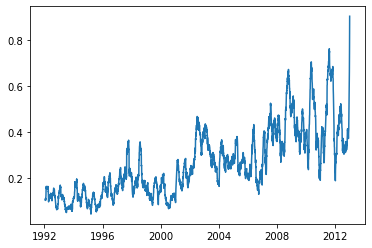

In [130]:
time = np.linspace(0,1,data.size)
print(data.shape)
plt.plot(Dates,data)
plt.show()

In [108]:
window_size = 1000
window_shift = 10
time_window = np.zeros(window_size)
data_window = np.zeros(window_size)
loop_range = np.arange(0, data.size - window_size + 1, window_shift)
# print(loop_range)
# print(data[4251:5251])
cp_prob_per_window = np.zeros((loop_range.size, window_size - 2))
cp_configs_per_window = np.zeros((loop_range.size, window_size - 2, 3))
ii = 0

In [109]:

# In der Schleife werden die Fenster der Größe window_size um window_shift verschoben.
for i in loop_range:
	data_window = np.roll(data, shift = -i)[:window_size]
	time_window = np.roll(time, shift = -i)[:window_size]

	CP_finance = CPSegmentFit(time_window, data_window, number_expected_changepoints = 1, num_MC_cp_samples = 1000000, predict_up_to = None, z_array_size = 100)
	# print(CP_finance.num_of_cp_configs)
	CP_finance.initialize_MC_cp_configurations(print_sum_control = True)
	CP_finance.initialize_A_matrices()
	try:
		CP_finance.Q_matrix_and_inverse_Q()
	except np.linalg.LinAlgError as err:
		if 'Singular matrix' in str(err):
			CP_finance.initialize_MC_cp_configurations()
			CP_finance.initialize_A_matrices()
	CP_finance.calculate_f0()
	CP_finance.calculate_residue()
	CP_finance.calculate_marginal_likelihood()
	CP_finance.calculate_marginal_cp_pdf()
	CP_finance.calculate_prob_cp()
	# Trage alle Konfigurationen eines Fensters in cp_configs_per_window ein.
	cp_configs_per_window[ii,:,:] = CP_finance.MC_cp_configurations
	# Trage die Wahrscheinlichkeitsverteilung des Fensters in cp_prob_per_window ein.
	cp_prob_per_window[ii,:] = CP_finance.prob_cp
	ii += 1
	print(i,ii)

number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
0 1
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
10 2
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
20 3
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
30 4
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
40 5
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
50 6
number of MC cp samples before exact correction:  1000000
n

/tmp/ipykernel_702245/1482644120.py:276: RuntimeWarning: overflow encountered in double_scalars
  self.marginal_cp_pdf = 1. / normalizing_Z_factor * marginal_cp_pdf
/tmp/ipykernel_702245/1482644120.py:276: RuntimeWarning: invalid value encountered in multiply
  self.marginal_cp_pdf = 1. / normalizing_Z_factor * marginal_cp_pdf


3120 313
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3130 314
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3140 315
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3150 316
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3160 317
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3170 318
number of MC cp samples before exact correction:  1000000
number of MC cp samples:  998
Less configurations than MC sample proposal. Compute exact sum!
3180 319
number of MC cp samples b

In [110]:
cp_prob_per_window.shape, cp_configs_per_window.shape

((430, 998), (430, 998, 3))

In [111]:
cp_configs_per_window

array([[[0.00000000e+00, 1.89071658e-04, 1.88882587e-01],
        [0.00000000e+00, 3.78143316e-04, 1.88882587e-01],
        [0.00000000e+00, 5.67214974e-04, 1.88882587e-01],
        ...,
        [0.00000000e+00, 1.88315372e-01, 1.88882587e-01],
        [0.00000000e+00, 1.88504443e-01, 1.88882587e-01],
        [0.00000000e+00, 1.88693515e-01, 1.88882587e-01]],

       [[1.89071658e-03, 2.07978824e-03, 1.90773303e-01],
        [1.89071658e-03, 2.26885990e-03, 1.90773303e-01],
        [1.89071658e-03, 2.45793156e-03, 1.90773303e-01],
        ...,
        [1.89071658e-03, 1.90206088e-01, 1.90773303e-01],
        [1.89071658e-03, 1.90395160e-01, 1.90773303e-01],
        [1.89071658e-03, 1.90584231e-01, 1.90773303e-01]],

       [[3.78143316e-03, 3.97050482e-03, 1.92664020e-01],
        [3.78143316e-03, 4.15957648e-03, 1.92664020e-01],
        [3.78143316e-03, 4.34864814e-03, 1.92664020e-01],
        ...,
        [3.78143316e-03, 1.92096805e-01, 1.92664020e-01],
        [3.78143316e-03, 1.92

In [112]:

# Speichere Konfigurationen und Wahrscheinlichkeiten.
np.save('cp_prob_per_window_ws' + str(window_size) + '.npy', cp_prob_per_window)
np.save('cp_configs_per_window_ws' + str(window_size) + '.npy', cp_configs_per_window)

/tmp/ipykernel_702245/236368148.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('composite_cp_result_ws' + str(window_size) + '_Safety'+str(safetymargin)


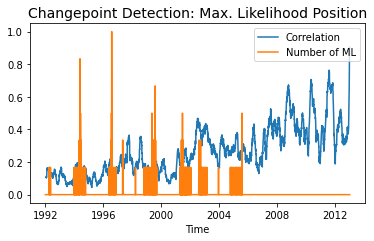

In [153]:

# Berechne und speichere composite_cp_result. Dabei werden die ML x-Werte ausgelesen und jeweils
# an ihrer Position diskret aufsummiert (je +1). Der erstellte Plot muss normalerweise runterskaliert werden,
# da er sonst mit dem Auge nicht mit den Daten vergleichbar ist.
composite_cp_result = np.zeros(data.size)
ii = 0
for i in loop_range:
	if np.max(cp_prob_per_window[ii,safetymargin:-safetymargin]).size == 1 and np.any(cp_prob_per_window[ii,safetymargin:-safetymargin] > 0) and  np.prod(np.isfinite(cp_prob_per_window[ii,:])):
		composite_cp_result[i + np.where(cp_prob_per_window[ii,safetymargin:-safetymargin] == np.max(cp_prob_per_window[ii,safetymargin:-safetymargin])) + 1] += 1
	ii += 1

np.save('composite_cp_result_ws' + str(window_size) + '.npy', composite_cp_result)
fig = plt.gcf()
fig.set_size_inches(6, 3.3)
plt.plot(Dates, data, label="Correlation")
plt.title("Changepoint Detection: Max. Likelihood Position", fontsize = 14)
plt.xlabel("Time")
plt.plot(Dates,composite_cp_result/max(composite_cp_result), label="Number of ML")
plt.legend(loc= "upper right")
plt.savefig('composite_cp_result_ws' + str(window_size) + '_Safety'+str(safetymargin)
			+'_Shift'+str(window_shift) + '.pdf',bb_inches="tight", dpi=200)
plt.show()
plt.close()

In [123]:
composite_cp_result.shape

(5290,)

430


/tmp/ipykernel_702245/2607810592.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('composite_prob_cp_result_ws' + str(window_size) + '_Safety'+str(safetymargin)


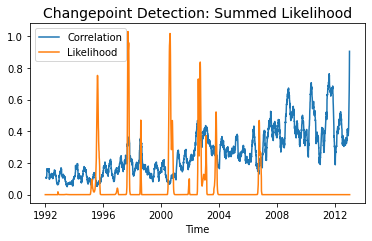

Computation completed.


In [145]:

# Hier werden die Wahrscheinlichkeitsverteilungen der jeweiligen Fenster aufsummiert. Dabei entsteht
# keine normierte neue Verteilung, aber ein sinnvoller Gesamtüberblick über die Resultate.

# print(np.arange(1+safetymargin,window_size-1-safetymargin).shape)
# print(cp_prob_per_window[0,safetymargin:-safetymargin].shape)

composite_prob_cp_result = np.zeros(data.size)
ii = 0
for i in loop_range:

	# check for nans and infs
	if np.prod(np.isfinite(cp_prob_per_window[ii,:])):
		composite_prob_cp_result[i + 1 +safetymargin: i + window_size - 1-safetymargin] += cp_prob_per_window[ii,safetymargin:-safetymargin]
	ii += 1
print(ii)
np.save('composite_prob_cp_result_ws' + str(window_size) + '.npy', composite_prob_cp_result)
fig = plt.gcf()
fig.set_size_inches(6, 3.3)
plt.plot(Dates, data, label="Correlation")
plt.plot(Dates, composite_prob_cp_result, label = "Likelihood")
plt.title("Changepoint Detection: Summed Likelihood", fontsize = 14)
plt.xlabel("Time")
plt.legend()
plt.savefig('composite_prob_cp_result_ws' + str(window_size) + '_Safety'+str(safetymargin)
			+'_Shift'+str(window_shift) + '.pdf',bb_inches="tight", dpi=200)
plt.show()
print('Computation completed.')